# Traditional ML Classifiers for Algae Classification

This notebook implements traditional machine learning classifiers to classify algae in microscopy images:
- **Decision Tree**
- **Random Forest**
- **XGBoost**
- **Artificial Neural Network (ANN)**

## Workflow:
1. Load features from Fisher discriminant analysis
2. Extract features from YOLO-labeled data (size and color)
3. Train traditional ML classifiers
4. Detect algae in images and classify them
5. Evaluate performance on test set

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm
import yaml
import pickle

# ML libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load configuration
config_path = Path('../configs/config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Define paths
data_root = Path('../data')
train_images = data_root / 'train' / 'images'
train_labels = data_root / 'train' / 'labels'
test_images = data_root / 'test' / 'images'
test_labels = data_root / 'test' / 'labels'
outputs_dir = Path('../outputs')

# Class names
class_names = config['data']['classes']
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

Number of classes: 6
Classes: ['Platymonas', 'Chlorella', 'Dunaliella salina', 'Effrenium', 'Porphyridium', 'Haematococcus']


## 1. Load Recommended Features from Fisher Analysis

In [3]:
# Load recommended features from Fisher discriminant analysis
fisher_features_df = pd.read_csv(outputs_dir / 'recommended_features.csv')
selected_features = fisher_features_df['Feature'].tolist()

print(f"Selected features ({len(selected_features)}):")
print(fisher_features_df)
print(f"\nFeature list: {selected_features}")

Selected features (8):
          Feature  Fisher_Score  Rank   Category
0  bbox_perimeter     10.624767     1      Shape
1      bbox_width      9.036763     2      Shape
2     bbox_height      9.031463     3      Shape
3       bbox_area      7.555700     4      Shape
4          kurt_B      0.958910     5  RGB Color
5          skew_B      0.937644     6  RGB Color
6           std_S      0.866320     7  HSV Color
7           std_B      0.506119     8  RGB Color

Feature list: ['bbox_perimeter', 'bbox_width', 'bbox_height', 'bbox_area', 'kurt_B', 'skew_B', 'std_S', 'std_B']


## 2. Feature Extraction Functions

We'll extract the selected features from algae bounding boxes in images.

In [4]:
def extract_color_features(image: np.ndarray) -> Dict[str, float]:
    """
    Extract color-based features from image.
    
    Args:
        image: RGB image array
    
    Returns:
        Dictionary of color features
    """
    features = {}
    
    # RGB statistics
    for i, channel in enumerate(['R', 'G', 'B']):
        features[f'mean_{channel}'] = np.mean(image[:, :, i])
        features[f'std_{channel}'] = np.std(image[:, :, i])
        features[f'skew_{channel}'] = float(pd.Series(image[:, :, i].flatten()).skew())
        features[f'kurt_{channel}'] = float(pd.Series(image[:, :, i].flatten()).kurtosis())
    
    # HSV statistics
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    for i, channel in enumerate(['H', 'S', 'V']):
        features[f'mean_{channel}'] = np.mean(hsv[:, :, i])
        features[f'std_{channel}'] = np.std(hsv[:, :, i])
    
    return features


def extract_shape_features(image: np.ndarray, bbox: List[float]) -> Dict[str, float]:
    """
    Extract shape features from bounding box.
    
    Args:
        image: RGB image array
        bbox: [x_center, y_center, width, height] in normalized coordinates
    
    Returns:
        Dictionary of shape features
    """
    h, w = image.shape[:2]
    
    # Convert normalized to pixel coordinates
    x_center, y_center, box_w, box_h = bbox
    box_w_px = box_w * w
    box_h_px = box_h * h
    
    features = {}
    features['bbox_width'] = float(box_w_px)
    features['bbox_height'] = float(box_h_px)
    features['bbox_area'] = float(box_w_px * box_h_px)
    features['bbox_aspect_ratio'] = float(box_w_px / (box_h_px + 1e-6))
    features['bbox_perimeter'] = float(2 * (box_w_px + box_h_px))
    
    # Circularity approximation
    perimeter = features['bbox_perimeter']
    area = features['bbox_area']
    features['circularity'] = float(4 * np.pi * area / (perimeter ** 2 + 1e-6))
    
    return features


def extract_features_from_bbox(image: np.ndarray, bbox: List[float]) -> Dict[str, float]:
    """
    Extract all selected features from a bounding box region.
    
    Args:
        image: Full RGB image
        bbox: [x_center, y_center, width, height] in normalized coordinates
    
    Returns:
        Dictionary of features
    """
    features = {}
    
    # Extract color features from full image (as in Fisher notebook)
    features.update(extract_color_features(image))
    
    # Extract shape features
    features.update(extract_shape_features(image, bbox))
    
    return features


def extract_dataset_features(images_dir: Path, labels_dir: Path) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Extract features from all images in a dataset.
    
    Args:
        images_dir: Directory containing images
        labels_dir: Directory containing YOLO format labels
    
    Returns:
        DataFrame of features and array of labels
    """
    all_features = []
    all_labels = []
    
    image_files = sorted(list(images_dir.glob('*.jpg')))
    
    for img_path in tqdm(image_files, desc="Extracting features"):
        label_path = labels_dir / (img_path.stem + '.txt')
        
        if not label_path.exists():
            continue
        
        try:
            # Load image
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load labels
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue
                    
                    class_id = int(parts[0])
                    bbox = [float(x) for x in parts[1:5]]
                    
                    # Extract features
                    features = extract_features_from_bbox(image, bbox)
                    all_features.append(features)
                    all_labels.append(class_id)
                    
        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")
            continue
    
    df_features = pd.DataFrame(all_features)
    labels = np.array(all_labels)
    
    return df_features, labels


print("Feature extraction functions defined!")

Feature extraction functions defined!


## 3. Extract Features from Training and Test Sets

In [5]:
# Extract training features
print("Extracting training features...")
X_train_full, y_train = extract_dataset_features(train_images, train_labels)

print(f"\nTraining set:")
print(f"  Samples: {len(y_train)}")
print(f"  Features: {X_train_full.shape[1]}")
print(f"  Classes: {np.unique(y_train)}")

# Select only the recommended features
X_train = X_train_full[selected_features]
print(f"\nUsing {len(selected_features)} selected features")

Extracting training features...


Extracting features: 100%|██████████| 700/700 [02:34<00:00,  4.53it/s]



Training set:
  Samples: 1758
  Features: 24
  Classes: [0 1 2 3 4 5]

Using 8 selected features


In [6]:
# Extract test features
print("Extracting test features...")
X_test_full, y_test = extract_dataset_features(test_images, test_labels)

print(f"\nTest set:")
print(f"  Samples: {len(y_test)}")
print(f"  Features: {X_test_full.shape[1]}")
print(f"  Classes: {np.unique(y_test)}")

# Select only the recommended features
X_test = X_test_full[selected_features]

Extracting test features...


Extracting features: 100%|██████████| 300/300 [12:15<00:00,  2.45s/it]


Test set:
  Samples: 1627
  Features: 24
  Classes: [0 1 2 3 4 5]


## 4. Feature Scaling

Standardize features for better performance with ANN and other algorithms.

In [7]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized!")
print(f"Mean: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Std: {X_train_scaled.std(axis=0)[:5]}")

Features standardized!
Mean: [-1.09127724e-16 -2.82923729e-17 -1.61670702e-16  1.61670702e-17
 -2.34422518e-16]
Std: [1. 1. 1. 1. 1.]


## 5. Model Training

### 5.1 Decision Tree Classifier

In [8]:
print("Training Decision Tree Classifier...")

# Hyperparameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid search with cross-validation
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(
    dt_classifier, 
    dt_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {dt_grid_search.best_params_}")
print(f"Best cross-validation score: {dt_grid_search.best_score_:.4f}")

# Best model
dt_best = dt_grid_search.best_estimator_

Training Decision Tree Classifier...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.7639


### 5.2 Random Forest Classifier

In [9]:
print("Training Random Forest Classifier...")

# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid search with cross-validation
rf_classifier = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(
    rf_classifier, 
    rf_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation score: {rf_grid_search.best_score_:.4f}")

# Best model
rf_best = rf_grid_search.best_estimator_

Training Random Forest Classifier...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.7890


### 5.3 XGBoost Classifier

In [10]:
print("Training XGBoost Classifier...")

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with cross-validation
xgb_classifier = xgb.XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgb_grid_search = GridSearchCV(
    xgb_classifier, 
    xgb_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {xgb_grid_search.best_params_}")
print(f"Best cross-validation score: {xgb_grid_search.best_score_:.4f}")

# Best model
xgb_best = xgb_grid_search.best_estimator_

Training XGBoost Classifier...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\afara\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:25:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score: 0.7890


### 5.4 Artificial Neural Network (ANN)

In [11]:
print("Training Artificial Neural Network...")

# Hyperparameter grid for ANN
ann_param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500]
}

# Grid search with cross-validation
ann_classifier = MLPClassifier(random_state=42, early_stopping=True)
ann_grid_search = GridSearchCV(
    ann_classifier, 
    ann_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

ann_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {ann_grid_search.best_params_}")
print(f"Best cross-validation score: {ann_grid_search.best_score_:.4f}")

# Best model
ann_best = ann_grid_search.best_estimator_

Training Artificial Neural Network...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 500}
Best cross-validation score: 0.7452


## 6. Model Evaluation

In [12]:
# Evaluate all models
models = {
    'Decision Tree': dt_best,
    'Random Forest': rf_best,
    'XGBoost': xgb_best,
    'ANN': ann_best
}

results = {}

for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")


Decision Tree:
  Accuracy:  0.6595
  Precision: 0.6966
  Recall:    0.6595
  F1-Score:  0.6553

Random Forest:
  Accuracy:  0.7554
  Precision: 0.7747
  Recall:    0.7554
  F1-Score:  0.7603

XGBoost:
  Accuracy:  0.7566
  Precision: 0.7621
  Recall:    0.7566
  F1-Score:  0.7562

ANN:
  Accuracy:  0.5575
  Precision: 0.6842
  Recall:    0.5575
  F1-Score:  0.5698


In [13]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
        Model  Accuracy  Precision   Recall  F1-Score
      XGBoost  0.756607   0.762072 0.756607  0.756174
Random Forest  0.755378   0.774745 0.755378  0.760339
Decision Tree  0.659496   0.696570 0.659496  0.655273
          ANN  0.557468   0.684231 0.557468  0.569799


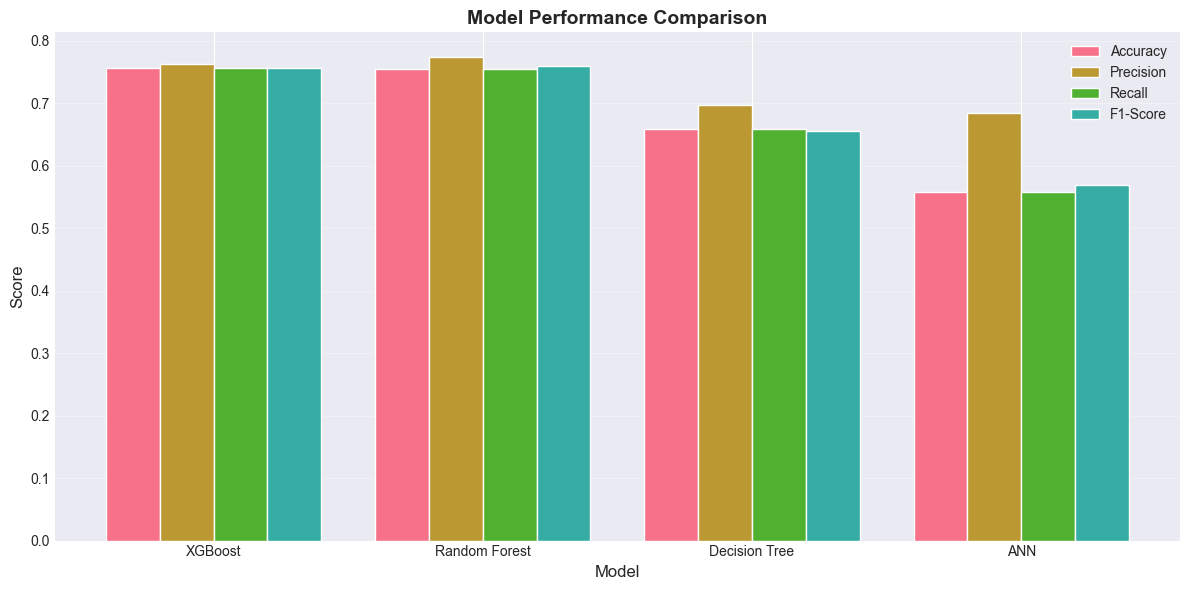

In [14]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.2

ax.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, comparison_df['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, comparison_df['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(outputs_dir / 'ml_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Confusion Matrices

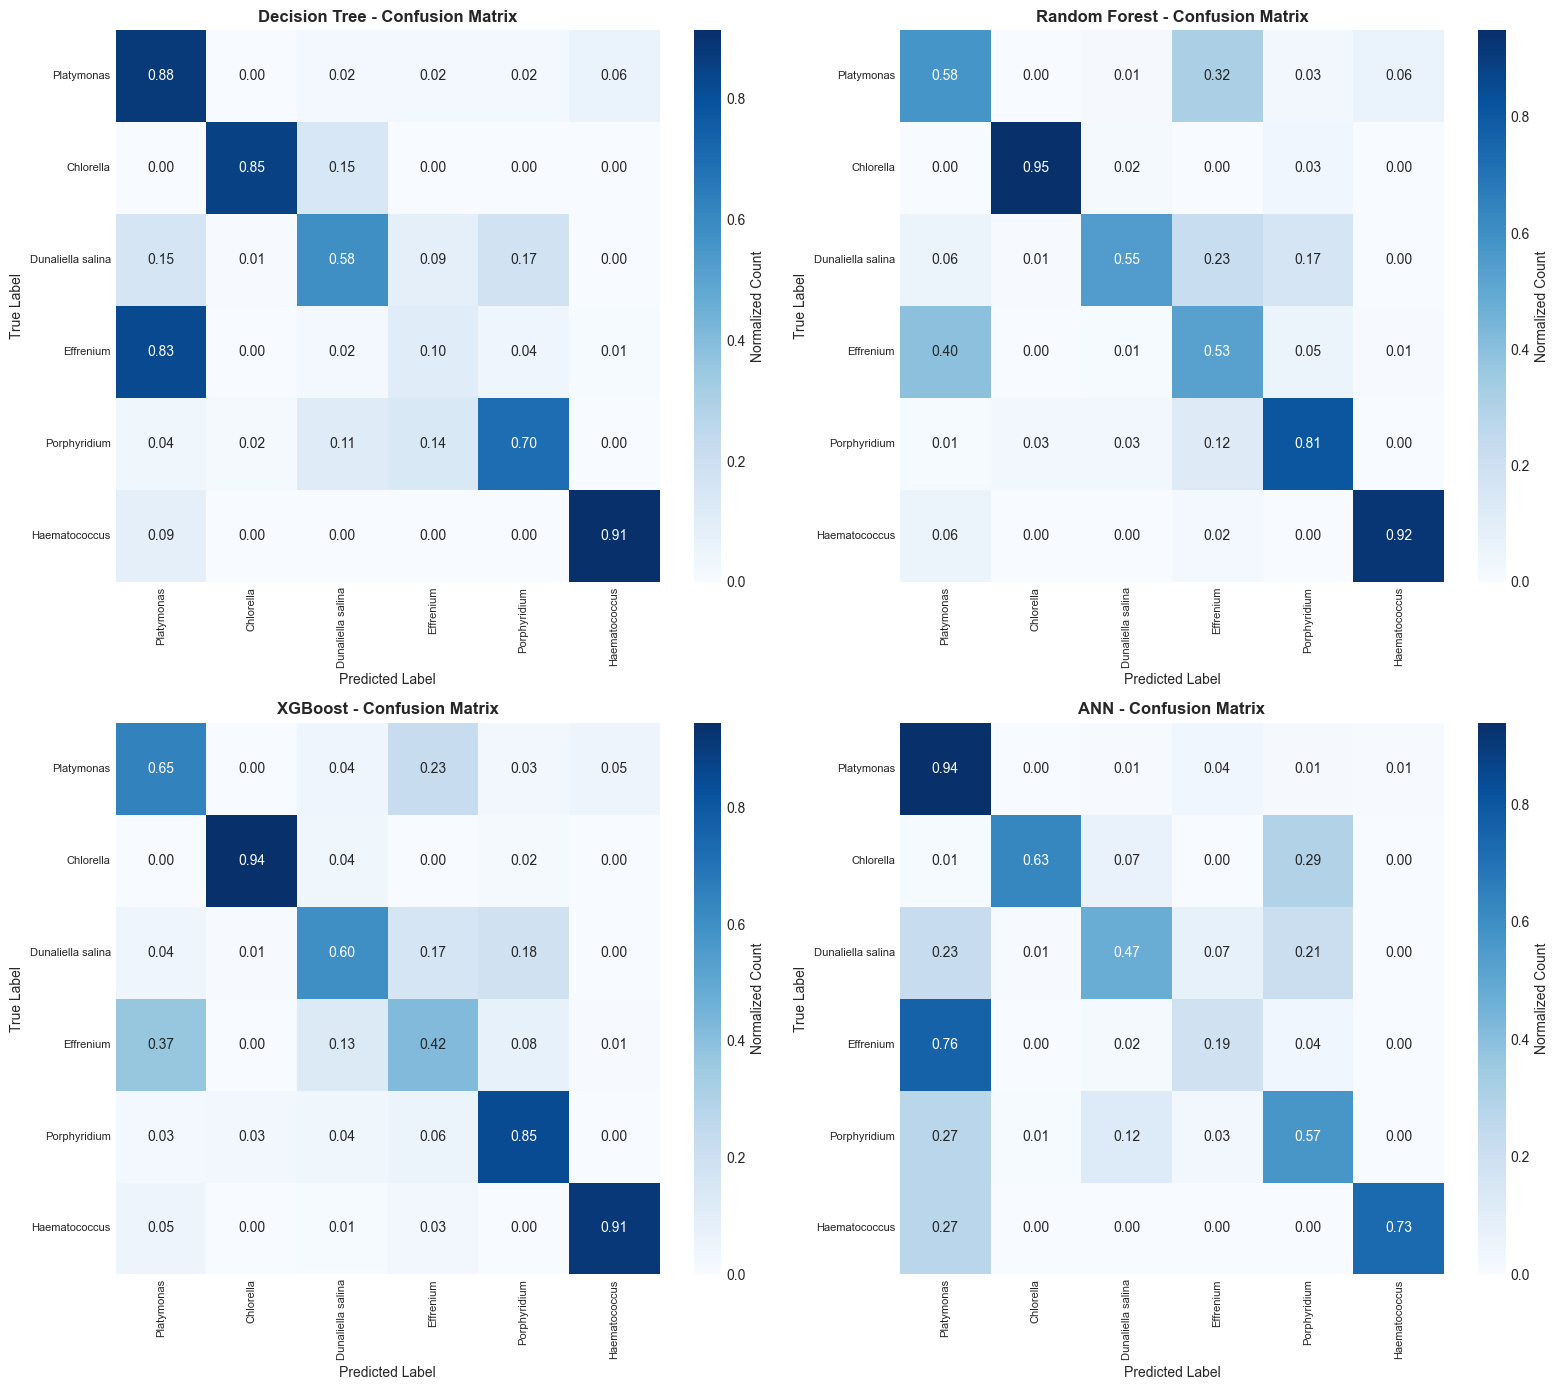

In [15]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    y_pred = results[name]['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[idx],
        cbar_kws={'label': 'Normalized Count'}
    )
    
    axes[idx].set_title(f'{name} - Confusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.savefig(outputs_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Classification Reports

In [16]:
# Print detailed classification reports
for name, model in models.items():
    y_pred = results[name]['predictions']
    print(f"\n{'='*60}")
    print(f"{name} - Classification Report")
    print(f"{'='*60}")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


Decision Tree - Classification Report
                   precision    recall  f1-score   support

       Platymonas       0.34      0.88      0.49       164
        Chlorella       0.98      0.85      0.91       486
Dunaliella salina       0.48      0.58      0.53       200
        Effrenium       0.28      0.10      0.15       278
     Porphyridium       0.85      0.70      0.76       395
    Haematococcus       0.89      0.91      0.90       104

         accuracy                           0.66      1627
        macro avg       0.64      0.67      0.62      1627
     weighted avg       0.70      0.66      0.66      1627


Random Forest - Classification Report
                   precision    recall  f1-score   support

       Platymonas       0.42      0.58      0.49       164
        Chlorella       0.97      0.95      0.96       486
Dunaliella salina       0.82      0.55      0.66       200
        Effrenium       0.50      0.53      0.51       278
     Porphyridium       0.82     

## 9. Save Best Model

Save the best performing model for future use.

In [17]:
# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"Best model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")

# Save model and scaler
model_save_path = outputs_dir / f'best_ml_model_{best_model_name.lower().replace(" ", "_")}.pkl'
scaler_save_path = outputs_dir / 'feature_scaler.pkl'

with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)

with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"\nModel saved to: {model_save_path}")
print(f"Scaler saved to: {scaler_save_path}")

Best model: XGBoost
Accuracy: 0.7566

Model saved to: ..\outputs\best_ml_model_xgboost.pkl
Scaler saved to: ..\outputs\feature_scaler.pkl


## 10. Algae Detection and Classification Pipeline

This section demonstrates how to detect algae in new images and classify them using the trained model.

In [18]:
def detect_and_classify_algae(image_path: Path, model, scaler, confidence_threshold=0.5):
    """
    Detect and classify algae in an image.
    
    Note: This is a simplified version. In practice, you would need:
    1. A proper object detection model (like YOLO) to find algae bounding boxes
    2. Then use the ML classifier to classify each detected algae
    
    For this demo, we'll use the ground truth bounding boxes from labels.
    
    Args:
        image_path: Path to image
        model: Trained classifier
        scaler: Feature scaler
        confidence_threshold: Minimum confidence for classification
    
    Returns:
        Image with detections, list of predictions
    """
    # Load image
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Load corresponding label file
    label_path = image_path.parent.parent / 'labels' / (image_path.stem + '.txt')
    
    predictions = []
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                
                true_class = int(parts[0])
                bbox = [float(x) for x in parts[1:5]]
                
                # Extract features
                features = extract_features_from_bbox(image_rgb, bbox)
                feature_vector = np.array([features[f] for f in selected_features]).reshape(1, -1)
                
                # Scale features
                feature_vector_scaled = scaler.transform(feature_vector)
                
                # Predict
                pred_class = model.predict(feature_vector_scaled)[0]
                
                # Get probability if available
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(feature_vector_scaled)[0]
                    confidence = proba[pred_class]
                else:
                    confidence = 1.0
                
                # Convert bbox to pixel coordinates
                x_center, y_center, box_w, box_h = bbox
                x1 = int((x_center - box_w/2) * w)
                y1 = int((y_center - box_h/2) * h)
                x2 = int((x_center + box_w/2) * w)
                y2 = int((y_center + box_h/2) * h)
                
                # Draw bounding box
                color = (0, 255, 0) if pred_class == true_class else (255, 0, 0)
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                
                # Add label
                label = f"{class_names[pred_class]}: {confidence:.2f}"
                cv2.putText(image, label, (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
                predictions.append({
                    'true_class': true_class,
                    'pred_class': pred_class,
                    'confidence': confidence,
                    'bbox': bbox
                })
    
    return image, predictions


print("Detection and classification function defined!")

Detection and classification function defined!


C:\Users\afara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\afara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\afara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\afara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\afara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: U

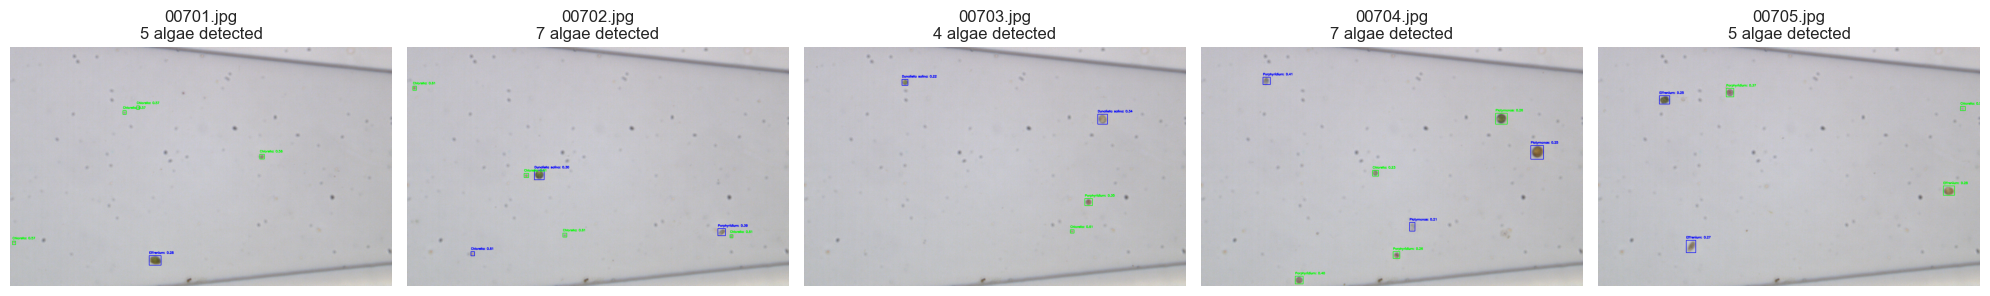


Green boxes: Correct predictions
Red boxes: Incorrect predictions


In [19]:
# Test on a few sample images
sample_images = list(test_images.glob('*.jpg'))[:5]

fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 4))

for idx, img_path in enumerate(sample_images):
    result_img, preds = detect_and_classify_algae(img_path, best_model, scaler)
    
    # Convert BGR to RGB for display
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(result_img_rgb)
    axes[idx].set_title(f"{img_path.name}\n{len(preds)} algae detected")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(outputs_dir / 'detection_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGreen boxes: Correct predictions")
print("Red boxes: Incorrect predictions")

## 11. Summary and Conclusions

In [20]:
print("="*60)
print("SUMMARY OF TRADITIONAL ML CLASSIFIERS")
print("="*60)

print(f"\nDataset:")
print(f"  Training samples: {len(y_train)}")
print(f"  Test samples: {len(y_test)}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {class_names}")

print(f"\nFeatures:")
print(f"  Selected features: {len(selected_features)}")
print(f"  Feature selection method: Fisher Discriminant Analysis")

print(f"\nModels Trained:")
for name in models.keys():
    print(f"  - {name}")

print(f"\nBest Model: {best_model_name}")
print(f"  Accuracy: {best_accuracy:.4f}")

print(f"\nModel Ranking (by accuracy):")
for idx, row in comparison_df.iterrows():
    print(f"  {idx+1}. {row['Model']}: {row['Accuracy']:.4f}")

print("\n" + "="*60)

SUMMARY OF TRADITIONAL ML CLASSIFIERS

Dataset:
  Training samples: 1758
  Test samples: 1627
  Number of classes: 6
  Classes: ['Platymonas', 'Chlorella', 'Dunaliella salina', 'Effrenium', 'Porphyridium', 'Haematococcus']

Features:
  Selected features: 8
  Feature selection method: Fisher Discriminant Analysis

Models Trained:
  - Decision Tree
  - Random Forest
  - XGBoost
  - ANN

Best Model: XGBoost
  Accuracy: 0.7566

Model Ranking (by accuracy):
  3. XGBoost: 0.7566
  2. Random Forest: 0.7554
  1. Decision Tree: 0.6595
  4. ANN: 0.5575

